In [1]:
import lib
import numpy as np
import matplotlib.pyplot as plt

# Hartree Fock computation of the ground state of the Helium atom

In this Jupyter Notebook we are going to compare the groundstate energies obtained with the analytical formula for the two body integrals with Montecarlo integration. In both cases, the Self-Consistent Field method is used.

### Basis functions
First we write the basis we are going to use

In [2]:
ALPHA_1 =  0.298073
ALPHA_2 =  1.242567
ALPHA_3 =  5.782948
ALPHA_4 = 38.474970
ALPHA = [ALPHA_1, ALPHA_2, ALPHA_3,ALPHA_4]

def He_wf(x, y, z, n):
    """
    Evaluates the n^th eigenfunction of the Hydrogen atom with exponential coefficient alpha_i. 
    The units of x are atomic units. 

    Parameters
    ==========
    x, y, z : float or np.ndarray
        Position in which to evaluate the wave function
    n : int
        Number of the wave function

    Returns
    =======
    float or np.ndarray
    """

    if n == 1:
        alpha = ALPHA_1
    elif n == 2:
        alpha = ALPHA_2
    elif n == 3:
        alpha = ALPHA_3
    elif n == 4:
        alpha = ALPHA_4
    else:
        alpha = None

    r2 = x**2 + y**2 + z**2

    return np.exp(-alpha*r2)

def He_wf_basis(R,k):
    """
    Evaluates the k^th eigenfunction of the Hydrogen atom with exponential coefficient alpha_i. 
    The units of x are atomic units. 

    Parameters
    ==========
    R : np.ndarray(3,N)
        Position in which to evaluate the wave function
    k : int
        Number of the wave function

    Returns
    =======
    float or np.ndarray(N)
    """
    return He_wf(R[0],R[1],R[2],k)

We now write the functions to calculate the integrands of the two-body integrals

In [3]:
def integrand_2(R):
    r1 = R[:,0:3]
    r2 = R[:,3:6]
    r12 = np.sqrt(np.sum((r1 - r2)**2, axis=-1))
    return 1/r12

def norm_product(p, r, q, s):
    a = ALPHA[p-1] + ALPHA[q-1]
    b = ALPHA[r-1] + ALPHA[s-1]
    PROD = (np.pi/a)**1.5 * (np.pi/b)**1.5
    
    return PROD

def He_two_body_integrand(p, r, q, s):
    """
    Integrand that goes into the monte carlo method in order to compute the 
    two electron integrals.

    Parameters
    ==========
    indices : int np.ndarray(4)
        Indices of the wave function

    Returns
    =======
    function
    """
    
    f = lambda R: integrand_2(R)*norm_product(p, r, q, s)
    
    return f

### One- and two- body integral computations
We first initialize some necessary parameters

In [4]:
N_electrons = 2
N_basis = 4
N_points = 1000000
integrals_file_num = "integrals/integrals_He_num.npy" # numerical integrals
integrals_file_ana = "integrals/integrals_He_ana.npy" # numerical integrals

normalized_wf = False

max_iter_SCF = 500
eps_SCF = 1E-5
Delta_SCF = 0

The exact one-body integral function is

In [5]:
def analytical_1(p,q):
    I = 3*ALPHA[p-1]*ALPHA[q-1]*np.pi**(1.5)/(ALPHA[p-1] + ALPHA[q-1])**(5/2) - 4*np.pi/(ALPHA[p-1] + ALPHA[q-1])
    return I

The exact two-body integral function is

In [6]:
def analytical_2(p, r, q, s):
    I = 2*np.pi**2.5 / ((ALPHA[p-1] + ALPHA[q-1])*(ALPHA[r-1] + ALPHA[s-1])*np.sqrt((ALPHA[p-1] + ALPHA[q-1] + ALPHA[r-1] + ALPHA[s-1])))
    return I

The covariance function for the exponents of the gaussians is

In [7]:
def f_cov(p, r, q, s):
    cov = 0.5*np.diag([1/(ALPHA[p-1] + ALPHA[q-1])]*3 + [1/(ALPHA[r-1] + ALPHA[s-1])]*3)
    return cov

We then calculate and store the one- and two-body integrals using lib.py

In [8]:
# One- and Two-body integrals (numerical)
MC_args = {"f_cov":f_cov, "f_integrand":He_two_body_integrand, "N_points":N_points}
integrals_num = lib.integral_master(N_basis)
integrals_num.calculate(integrals_file_num, analytical_1, analytical_2=None, MC_args=MC_args)

# One- and Two-body integrals (analytical)
integrals_ana = lib.integral_master(N_basis)
integrals_ana.calculate(integrals_file_ana, analytical_1, analytical_2=analytical_2)

Integral file already exists. Not computing the integrals. 
Integral file already exists. Not computing the integrals. 


We calculate the overlap matrix S

In [9]:
S = np.zeros((4,4))
for p in range(4):
    for q in range(4):
        S[p][q] = (np.pi/(ALPHA[p]+ALPHA[q]))**(1.5)
SVAL, SVEC = np.linalg.eigh(S) 
SVAL_minhalf = (np.diag(SVAL**(-0.5))) 
X = np.dot(SVEC, np.dot(SVAL_minhalf, np.transpose(SVEC)))
print('S = \n',S)

S = 
 [[1.20975063e+01 2.91187719e+00 3.71330014e-01 2.30637530e-02]
 [2.91187719e+00 1.42134692e+00 2.99025043e-01 2.22459699e-02]
 [3.71330014e-01 2.99025043e-01 1.41564997e-01 1.89120383e-02]
 [2.30637530e-02 2.22459699e-02 1.89120383e-02 8.24921040e-03]]


### Self-Consistent Field (numerical integration)

Finally, we run the Self-Consistent Field for Hartree Fock

In [17]:
_ = lib.SCF(N_electrons, integrals_num, S, max_iter_SCF, eps_SCF)

E = -0.6042396 | N(SCF) = 1
E = -1.9433821 | N(SCF) = 2
E = -1.9110050 | N(SCF) = 3
E = -2.8296607 | N(SCF) = 4
E = -2.7210994 | N(SCF) = 5
E = -2.7427273 | N(SCF) = 6
E = -2.8095379 | N(SCF) = 7
E = -2.8607228 | N(SCF) = 8
E = -2.8511643 | N(SCF) = 9
E = -2.8448826 | N(SCF) = 10
E = -2.8505860 | N(SCF) = 11
E = -2.8611955 | N(SCF) = 12
E = -2.8281373 | N(SCF) = 13
E = -2.8763011 | N(SCF) = 14
E = -2.8276697 | N(SCF) = 15
E = -2.8880942 | N(SCF) = 16
E = -2.8357733 | N(SCF) = 17
E = -2.8392938 | N(SCF) = 18
E = -2.8438858 | N(SCF) = 19
E = -2.8897208 | N(SCF) = 20
E = -2.8051901 | N(SCF) = 21
E = -2.8767568 | N(SCF) = 22
E = -2.8443954 | N(SCF) = 23
E = -2.8741079 | N(SCF) = 24
E = -2.8283481 | N(SCF) = 25
E = -2.8640777 | N(SCF) = 26
E = -2.8362524 | N(SCF) = 27
E = -2.8688703 | N(SCF) = 28
E = -2.8501253 | N(SCF) = 29
E = -2.8475172 | N(SCF) = 30
E = -2.8600183 | N(SCF) = 31
E = -2.8603063 | N(SCF) = 32
E = -2.8393407 | N(SCF) = 33
E = -2.8766773 | N(SCF) = 34
E = -2.7857504 | N(SCF)

E = -2.8560997 | N(SCF) = 462
E = -2.8564930 | N(SCF) = 463
E = -2.8557096 | N(SCF) = 464
E = -2.8537531 | N(SCF) = 465
E = -2.8559317 | N(SCF) = 466
E = -2.8544696 | N(SCF) = 467
E = -2.8551191 | N(SCF) = 468
E = -2.8539290 | N(SCF) = 469
E = -2.8562939 | N(SCF) = 470
E = -2.8529945 | N(SCF) = 471
E = -2.8549742 | N(SCF) = 472
E = -2.8572131 | N(SCF) = 473
E = -2.8484411 | N(SCF) = 474
E = -2.8633646 | N(SCF) = 475
E = -2.8528375 | N(SCF) = 476
E = -2.8452359 | N(SCF) = 477
E = -2.8770347 | N(SCF) = 478
E = -2.7919115 | N(SCF) = 479
E = -2.8858811 | N(SCF) = 480
E = -2.7764887 | N(SCF) = 481
E = -2.8347614 | N(SCF) = 482
E = -2.9635726 | N(SCF) = 483
E = -2.6004218 | N(SCF) = 484
E = -2.8485174 | N(SCF) = 485
E = -2.9601180 | N(SCF) = 486
E = -2.8371099 | N(SCF) = 487
E = -2.8881615 | N(SCF) = 488
E = -2.8422356 | N(SCF) = 489
E = -2.8039077 | N(SCF) = 490
E = -2.8900528 | N(SCF) = 491
E = -2.8205756 | N(SCF) = 492
E = -2.8437067 | N(SCF) = 493
E = -2.8540136 | N(SCF) = 494
E = -2.883

### Self-Consistent Field (analytical integration)

Finally, we run the Self-Consistent Field for Hartree Fock

In [18]:
_ = lib.SCF(N_electrons, integrals_ana, S, max_iter_SCF, eps_SCF)

E = -2.8439921 | N(SCF) = 1
E = -2.7399774 | N(SCF) = 2
E = -2.7165229 | N(SCF) = 3
E = -2.8433812 | N(SCF) = 4
E = -2.7805373 | N(SCF) = 5
E = -2.8603455 | N(SCF) = 6
E = -2.8568954 | N(SCF) = 7
E = -2.8490452 | N(SCF) = 8
E = -2.8615266 | N(SCF) = 9
E = -2.8349428 | N(SCF) = 10
E = -2.9001743 | N(SCF) = 11
E = -2.6772109 | N(SCF) = 12
E = -3.0143114 | N(SCF) = 13
E = -2.5532448 | N(SCF) = 14
E = -2.7370146 | N(SCF) = 15
E = -2.9705445 | N(SCF) = 16
E = -2.6461280 | N(SCF) = 17
E = -3.0055466 | N(SCF) = 18
E = -2.6611203 | N(SCF) = 19
E = -2.7587670 | N(SCF) = 20
E = -2.9931236 | N(SCF) = 21
E = -2.6495647 | N(SCF) = 22
E = -2.8115719 | N(SCF) = 23
E = -3.0447424 | N(SCF) = 24
E = -2.7270375 | N(SCF) = 25
E = -2.8272550 | N(SCF) = 26
E = -2.8885693 | N(SCF) = 27
E = -2.9126861 | N(SCF) = 28
E = -2.7212346 | N(SCF) = 29
E = -2.8766014 | N(SCF) = 30
E = -2.8363893 | N(SCF) = 31
E = -2.9618906 | N(SCF) = 32
E = -2.4714217 | N(SCF) = 33
E = -3.0894006 | N(SCF) = 34
E = -2.6643960 | N(SCF)

E = -2.8374174 | N(SCF) = 383
E = -2.8796070 | N(SCF) = 384
E = -2.7706529 | N(SCF) = 385
E = -2.8995287 | N(SCF) = 386
E = -2.6260269 | N(SCF) = 387
E = -2.8437059 | N(SCF) = 388
E = -2.8429238 | N(SCF) = 389
E = -2.8372436 | N(SCF) = 390
E = -2.8263186 | N(SCF) = 391
E = -2.8724998 | N(SCF) = 392
E = -2.8633818 | N(SCF) = 393
E = -2.8547407 | N(SCF) = 394
E = -2.8502370 | N(SCF) = 395
E = -2.8542702 | N(SCF) = 396
E = -2.8560227 | N(SCF) = 397
E = -2.8571426 | N(SCF) = 398
E = -2.8563731 | N(SCF) = 399
E = -2.8560278 | N(SCF) = 400
E = -2.8540435 | N(SCF) = 401
E = -2.8557732 | N(SCF) = 402
E = -2.8548680 | N(SCF) = 403
E = -2.8555996 | N(SCF) = 404
E = -2.8543108 | N(SCF) = 405
E = -2.8589367 | N(SCF) = 406
E = -2.8419196 | N(SCF) = 407
E = -2.8965759 | N(SCF) = 408
E = -2.6351280 | N(SCF) = 409
E = -2.9006970 | N(SCF) = 410
E = -2.7539204 | N(SCF) = 411
E = -2.8489862 | N(SCF) = 412
E = -2.8717011 | N(SCF) = 413
E = -2.8555406 | N(SCF) = 414
E = -2.8841659 | N(SCF) = 415
E = -2.814

E = -2.9626039 | N(SCF) = 298
E = -2.6934824 | N(SCF) = 299
E = -2.7526002 | N(SCF) = 300
E = -2.7818040 | N(SCF) = 301
E = -2.8239892 | N(SCF) = 302
E = -2.9264031 | N(SCF) = 303
E = -2.7885843 | N(SCF) = 304
E = -2.8998850 | N(SCF) = 305
E = -2.6816560 | N(SCF) = 306
E = -2.9422116 | N(SCF) = 307
E = -2.7273191 | N(SCF) = 308
E = -2.7820677 | N(SCF) = 309
E = -2.9153950 | N(SCF) = 310
E = -2.8162643 | N(SCF) = 311
E = -2.8361617 | N(SCF) = 312
E = -2.9036986 | N(SCF) = 313
E = -2.6826745 | N(SCF) = 314
E = -2.7681761 | N(SCF) = 315
E = -2.8483723 | N(SCF) = 316
E = -2.9062625 | N(SCF) = 317
E = -2.8374131 | N(SCF) = 318
E = -2.8470275 | N(SCF) = 319
E = -2.8629612 | N(SCF) = 320
E = -2.8529194 | N(SCF) = 321
E = -2.8610532 | N(SCF) = 322
E = -2.8549305 | N(SCF) = 323
E = -2.8555168 | N(SCF) = 324
E = -2.8557285 | N(SCF) = 325
E = -2.8550773 | N(SCF) = 326
E = -2.8551542 | N(SCF) = 327
E = -2.8555147 | N(SCF) = 328
E = -2.8548852 | N(SCF) = 329
E = -2.8553850 | N(SCF) = 330
E = -2.854

### Assessment of the errors

In this final section, we are going to get an approximate order of the errors done in the Monte Carlo integration and the SCF

#### Monte Carlo

In [12]:
# Average relative error
ERRORS = []
MC_integrals = integrals_num.integral_dict_2
ana_integrals = integrals_ana.integral_dict_2
for pqrs in MC_integrals:
    ERRORS += [[pqrs, np.abs(MC_integrals[pqrs] - ana_integrals[pqrs]), np.abs(MC_integrals[pqrs] - ana_integrals[pqrs])/ana_integrals[pqrs]]]

print("Relative error of MC integration: {:0.5f} %".format(np.average([i[2] for i in ERRORS])*100))
print("Standard deviation of MC integration error: {:0.5f} %".format(np.std([i[2] for i in ERRORS])*100))

Relative error of MC integration: 0.07346 %
Standard deviation of MC integration error: 0.04121 %


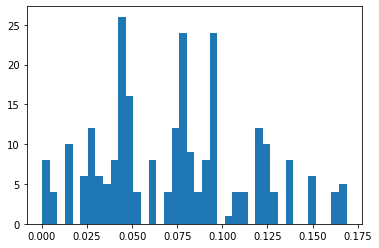

In [13]:
# Distribution of relative errors
ERRORS_REL = [i[2]*100 for i in ERRORS]
plt.hist(ERRORS_REL, bins=40)
plt.show()

In [14]:
# Maximum relative errors
TOP_ERR = sorted(ERRORS_REL, reverse=True)[:10]
for data in ERRORS:
    if data[2]*100 in TOP_ERR:
        print("pqrs =", *data[0], "| absolute error = {:0.7f}".format(data[1]))

pqrs = 3 3 3 1 | absolute error = 0.0001922
pqrs = 3 1 3 3 | absolute error = 0.0001922
pqrs = 3 3 1 3 | absolute error = 0.0001922
pqrs = 1 3 3 3 | absolute error = 0.0001922
pqrs = 3 3 3 3 | absolute error = 0.0000918
pqrs = 4 3 2 3 | absolute error = 0.0000175
pqrs = 2 3 4 3 | absolute error = 0.0000175
pqrs = 3 4 3 2 | absolute error = 0.0000175
pqrs = 3 2 3 4 | absolute error = 0.0000175
pqrs = 4 4 4 2 | absolute error = 0.0000016
pqrs = 4 2 4 4 | absolute error = 0.0000016
pqrs = 4 4 2 4 | absolute error = 0.0000016
pqrs = 2 4 4 4 | absolute error = 0.0000016


In [15]:
# Maximum absolute errors
ERRORS_ABS = [i[1] for i in ERRORS]
TOP_ERR = sorted(ERRORS_ABS, reverse=True)[:10]
for data in ERRORS:
    if data[1] in TOP_ERR:
        print("pqrs =", *data[0], "| absolute error = {:0.7f}".format(data[1]), "| relative error = {:0.7f}".format(data[2]*100))

pqrs = 1 1 1 1 | absolute error = 0.0921757 | relative error = 0.1022371
pqrs = 2 1 1 1 | absolute error = 0.0251999 | relative error = 0.0967003
pqrs = 1 1 2 1 | absolute error = 0.0251999 | relative error = 0.0967003
pqrs = 1 2 1 1 | absolute error = 0.0251999 | relative error = 0.0967003
pqrs = 1 1 1 2 | absolute error = 0.0251999 | relative error = 0.0967003
pqrs = 2 1 2 1 | absolute error = 0.0166859 | relative error = 0.1240263
pqrs = 1 2 1 2 | absolute error = 0.0166859 | relative error = 0.1240263
pqrs = 2 2 2 1 | absolute error = 0.0059375 | relative error = 0.1303701
pqrs = 2 1 2 2 | absolute error = 0.0059375 | relative error = 0.1303701
pqrs = 2 2 1 2 | absolute error = 0.0059375 | relative error = 0.1303701
pqrs = 1 2 2 2 | absolute error = 0.0059375 | relative error = 0.1303701


#### Self-Consisten Field

In [21]:
N = 100 # repetitions of the SCF field
total_energies_num = []
total_energies_ana = []

for i in range(N):
    print("\r{}/{}".format(i+1, N), end="")
    E_num = lib.SCF(N_electrons, integrals_num, S, max_iter_SCF, eps_SCF, print_E=False)
    total_energies_num += [E_num]
    E_ana = lib.SCF(N_electrons, integrals_num, S, max_iter_SCF, eps_SCF, print_E=False)
    total_energies_ana += [E_ana]

100/100

In [24]:
print("E(SCF numerical)  = {:0.7f} +- {:0.7f}".format(np.average(total_energies_num), np.std(total_energies_num)))
print("E(SCF analytical) = {:0.7f} +- {:0.7f}".format(np.average(total_energies_ana), np.std(total_energies_ana)))

E(SCF numerical)  = -2.8540255 +- 0.0030729
E(SCF analytical) = -2.8542953 +- 0.0043931


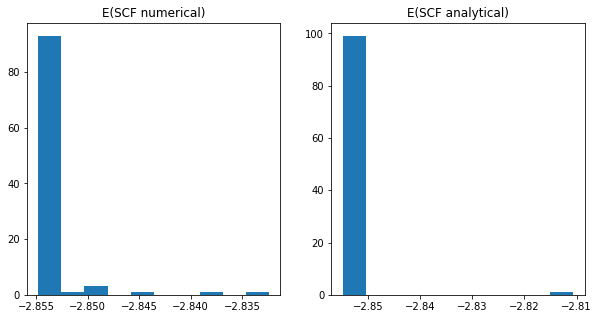

In [28]:
fig = plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(121)
ax1.hist(total_energies_num)
ax1.set_title("E(SCF numerical)")
ax2 = fig.add_subplot(122)
ax2.hist(total_energies_ana)
ax2.set_title("E(SCF analytical)")
plt.show()